In [ ]:
from scipy import stats, optimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
from scipy.special import factorial
from tabulate import tabulate

# Note

This notebook and the relevant experiments were conducted as a part of the course "Intermediate Physics Laboratory" under the guidance of Prof. Elena Aprile of the Physics department. I took this course on Fall 2019. I updated texts and explanations on this notebook based on the final report I wrote for this experiment. 

# 1. Introduction

Silicone Photomultiplier(SiPM) has revolutionized the way photons are counted and measured. With increased fidelity and resolution, experimenters are able to plot and count photons. This experiment not only showcases the high accuracy of the SiPM, but also sheds light upon the discretized nature of photons. The distribution of photons are modeled as a superposition of Gaussian distributions, with each amplitude of a Gaussian following a Poisson distribution, while their width and mean follow a linear model.

## (A) Theoretical Background

One of the key aspects of the photoelectric effect is that the light intensity is proportional to the number of photons in the light. 

SiPM’s high single photo-electron resolution allows statistical analysis of photon distribution with high fidelity. LED driver can emit single photons with varying intensity. From the LED driver, the number of photons emitted is each a statistically independent event, meaning that the amount collected over time interval $\Delta$ t is only dependent on $\Delta$ t. This, along with the fact that charge is not continuous but discrete, means that the numbers of photons emitted within a given time interval follows a Poisson distribution (Arosio et al, 2013). The formula for a Poisson distribution goes: 

$
\begin{align}
P(k) = \frac{\lambda^{k} e^{-\lambda}}{k!}
\end{align} 
$

Note, that the Poisson distribution depends on only one parameter, $\lambda$, which represents the expected value or the mean of the Poisson distribution. In this case, it would represent the mean number of photons counted. $\textit{k}$ is the number of events in the interval, or in this case, the number of photons. 

However, the distribution of the number of charges would not follow an exact Poisson distribution, due to noise and statistical errors. In fact, even if all photon charge is discrete, the actual values measured by the SiPM would have a Gaussian distribution with the mean being the predicted charge of the photon. The formula for the standard Gaussian distribution goes as follows:

$P(x) = \frac{e^{-(x - \mu)^{2}/(2\sigma^{2}) }} {\sigma\sqrt{2\pi}}$

$\sigma$ represents the standard deviation which is proportional to the width of the Gaussian distribution. $\mu$ represents the mean or the center of the Gaussian distribution. Note that the Gaussian distribution that is not normalized has three parameters relevant: amplitude, mean, and standard deviation. Amplitude would represent the maximum height of the Gaussian peak. 

The gist is this: **as we increase the intensity of light (and thus the number of photons), SiPM will measure the peaks of the photon distribution as Poisson. Each individual peak, due to the noise in the measurement, will be Gaussian.** 



## (B) Experiment Setup

This  experiment  was  conducted  using  CAEN  SiliconPhotomultiplier Kit.  The Kit is equipped with followingdevices:    Power  and  Supply  and  Amplification  Unit(PSAU), Desktop Digitizer,  ultra-fast LED Driver,  and Sensor Holder with SiPM.


*   **SP5600 - Power  Supply  and  Amplification  Unit**: PSAU allows the experimenter to set bias for thesensors.  It also has a feedback mechanism to cali-brate against temperature variations (CAEN SpA,Quickstart  Guide, 2016).  Functionalities of PSAUthat  are  relevant  for  this  experiment  are  bias[V]and discriminator.  Bias refers to the offset in thebaseline settings of PSAU. Discriminator is a devicethat selectively process only certain signals abovea threshold value.  Threshold is the cutoff line usedto separate meaningful pulse from random signals.Thus,  settings  of  bias  and  threshold  can  changewhat PSAU considers an actual signal from back-ground noise (Leo, 1994).
*   **DT5720A** - **Desktop Digitizer**, with 2 input channels sampled by a 12-bit ADC, or analog-to-digital converters. ADC is a device which converts the information contained in an analog signal to an equivalent digital form (Leo, 1994). Digitizer processes the electric pulse from the input channel. It can perform charge integration to accurately calculate the charge for a predetermined window of time interval. It is especially possible to set the parameters for the gate[ns], pre-gate[ns], and hold-off[ns]. These parameters respectively control the width of, the starting point of, and the distance between each window of time interval for integrating each pulse (CAEN SpA,  \textit{Quickstart Guide}, 2016).
*   **SP5601 - LED Driver**: LED Driver emits pulses through an optical fiber. The LED Driver comes with a turnable intensity modifier. By turning the knob, one can control the intensity, and thus the number of photons, emitted from the LED Driver. It is also possible to control the frequency of the emitted light as well, using Low or High frequency switch.







The experiment schema will look like this: 

# 2. Measurement and Data

In order to see how the distribution of photon count change as a function of measured charge, there have been measurements over varying magnitudes of light intensity. Changes in light intensity were made by incrementing the turnable know in the LED Driver. The minimum knob level on LED Driver is 1.00, while the maximum level is 5.00, with the smallest unit being 0.02.  There have been thirty five measurements with different light intensity. Among those thirty five, thirty of them were made on the range between 1.00 and 4.00 intensity levels, with the increment of 0.10 per measurement. Between 4.00 to 4.80, the increment was raised to 0.20 per measurement, thus totaling five measurements between 4.00 and 4.80.


## (A) Data

Among the thirty-five measurements, three light intensities (3.00, 3.50, 4.00) were selected and the raw data distribution are shown below. There are five, nine, and fourteen peaks respectively for each distribution. The y-axis represents the photon count of each charge. The horizontal scale in ADC channels represents the charge that was integrated between the gate.

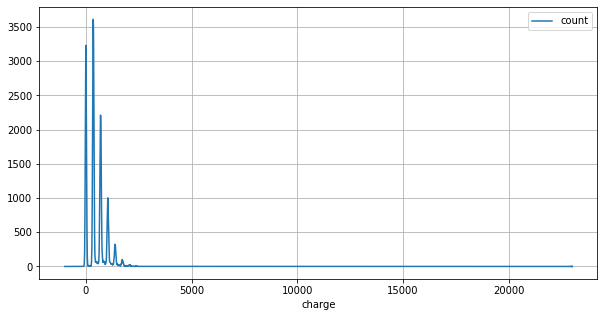

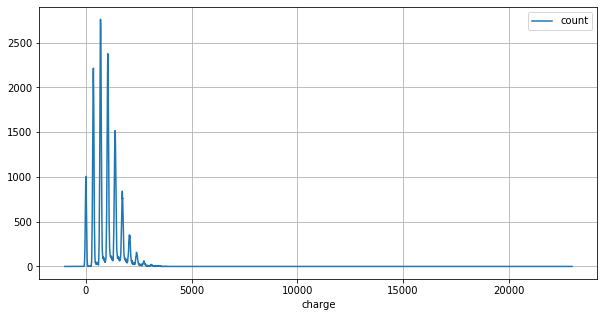

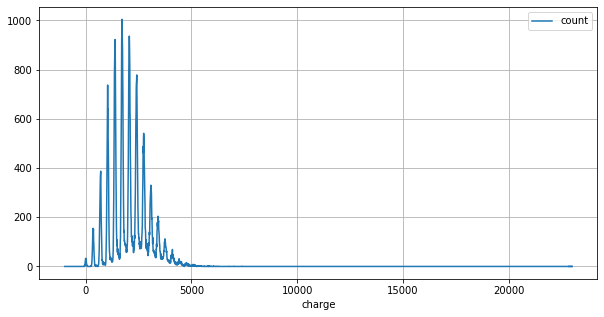

In [ ]:
path_300 = 'data/300_count_histo.txt'
count_300 = pd.read_csv(path_300, delimiter = '\t', names = ['charge','count'],header=5, sep='\s\s+', engine='c')
count_300.set_index('charge').plot(figsize=(10,5), grid=True)

path_350 = 'data/350_count_histo.txt'
count_350 = pd.read_csv(path_350, delimiter = '\t', names = ['charge','count'],header=5, sep='\s\s+', engine='c')
count_350.set_index('charge').plot(figsize=(10,5), grid=True)

path_400 = 'data/400_count_histo.txt'
count_400= pd.read_csv(path_400, delimiter = '\t', names = ['charge','count'],header=5, sep='\s\s+', engine='c')
count_400.set_index('charge').plot(figsize=(10,5), grid=True)

## (B) Multi-peak spectrum analysis
It is possible to fit the photon count distribution as a superposition of multiple Gaussian distributions, with its successive amplitudes following a Poisson distribution. In order to fit the photon distribution as such, each peak must first  be represented as a Gaussian. A Gaussian distribution, as mentioned above, has three parameters: amplitude, center, and the width. There will be three corresponding parameters for each peak, with the total number of Gaussian parameters depending on the number of peaks identified. \\

In order to fit each peak as a Gaussian, *curve-fit* method at SciPy library was used. The *curve-fit* method used non-linear least squares to optimize the best parameters that fit the given photon counting data. Similarly for Poisson distribution, *curve-fit* method was used again to estimate $\lambda$. \\

Now that we have imported the data, and have chosen three cases of varying chargee (3.00, 3.50, and 4.00), let's fit each model as a multi-peak Gaussian superposition. I'm eye-balling the number of peaks in this stage. For knob 3.00, there are five peaks, thus fit it with five Gaussian distributions. For amplitutde 3.50, there are nine. For 4.0, there are fourteen peaks. Each Gaussian distribution comes with three respective parameters (height, center, width), thus totalling the number of parameters as 3N. (N = # of Gaussian peaks). 

In [ ]:
def gaussian(x, height, center, width):
    return height*np.exp(-(x - center)**2/(2 *width**2))

def five_gaussian(x, h1, h2, h3, h4, h5, c1, c2, c3, c4, c5, w1, w2, w3, w4, w5):
    return (gaussian(x, h1, c1, w1) + gaussian(x, h2, c2, w2) + gaussian(x, h3, c3, w3) +
            gaussian(x, h4, c4, w4) + gaussian(x, h5, c5, w5) )
    
def nine_gaussian(x, 
                    h1, h2, h3, h4, h5, h6, h7, h8, h9,
                    c1, c2, c3, c4, c5, c6, c7, c8,  c9,
                    w1, w2 , w3, w4, w5, w6, w7, w8, w9,
                    ):
    return (gaussian(x, h1, c1, w1) + gaussian(x, h2, c2, w2) + gaussian(x, h3, c3, w3) +
            gaussian(x, h4, c4, w4) + gaussian(x, h5, c5, w5) + gaussian(x, h6, c6, w6) +
            gaussian(x, h7, c7, w7) + gaussian(x, h8, c8, w8) + gaussian(x, h9, c9, w9) )

def fourteen_gaussian(x, 
                    h1, h2, h3, h4, h5, h6, h7, h8, h9, ha, hb, hc, hd, he, 
                    c1, c2, c3, c4, c5, c6, c7, c8, c9, ca,cb, cc, cd, ce,  
                    w1, w2 , w3, w4, w5, w6, w7, w8, w9, wa,wb, wc,wd, we, 
                    ):
    return (gaussian(x, h1, c1, w1) + gaussian(x, h2, c2, w2) + gaussian(x, h3, c3, w3) +
            gaussian(x, h4, c4, w4) + gaussian(x, h5, c5, w5) + gaussian(x, h6, c6, w6) +
            gaussian(x, h7, c7, w7) + gaussian(x, h8, c8, w8) + gaussian(x, h9, c9, w9) +
            gaussian(x, ha  , ca , wa) + gaussian(x, hb , cb , wb) + gaussian(x, hc , cc , wc) +
            gaussian(x, hd  , cd , wd) + gaussian(x, he , ce , we))
    
# I am certain there are better numerical tools to express multi-peak Gaussian superpositions. 
# If anybody knows, please let me know! 

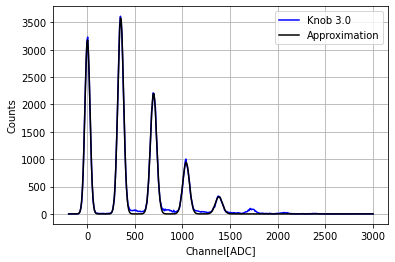

In [ ]:
x5_data = count_300.loc[100:500,'charge']
y5_data = count_300.loc[100:500,'count']

amp5 = [3600.24671793872,	3197.40525240181,	2211.80908269923,	943.269504174971,	312.633794921915]
mean5 = [0.804020605676679,	350.517319192303,	696.161856344542,	1038.41889409740,	1382.76049274475]
std5 = [42.7421478087270,	37.7659307780545,	46.3012991431860,	49.2761076963624,	53.3654744905733]

guess5 = amp5 + mean5 + std5

popt5, pcov5 = optimize.curve_fit(five_gaussian, x5_data, y5_data, guess5)

plt.plot(x5_data,y5_data, 'blue', label="Knob 3.0")
plt.plot(x5_data, five_gaussian(x5_data, *popt5), 'black' , label="Approximation")

#black_patch = mpatches.Patch(color='black', label='Knob 3.0')
#blue_patch = mpatches.Patch(color='blue', label='Approximation')
plt.xlabel('Channel[ADC]', fontsize=10)
plt.ylabel('Counts', fontsize=10)
plt.grid()
plt.legend()

#print(popt5)

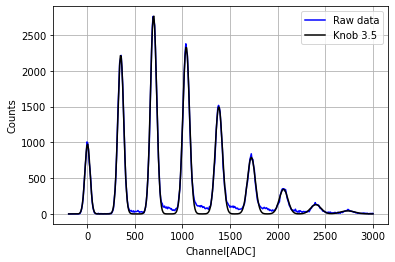

In [ ]:
x9_data = count_350.loc[100:500,'charge']
y9_data = count_350.loc[100:500,'count']

amp9 = [900, 1900, 2300, 2000,
        1300, 700, 300, 100,
        10]        
mean9 = [1.89930685203896,	350.499008376769,	696.203159165885,	1038.34744735898,
          1380.52775779933,	1721.16318888544,	2062.21294165426,	2402.23233086202,
         2700]
std9 = [3,	42.3552013550405,	4,	49.0659614850500,
         52.8802709358307,	56.8587501556161,	62.4974433900208,	66.6795835692384,
        71]

guess9 = amp9 + mean9 + std9
popt9, pcov9 = optimize.curve_fit(nine_gaussian, x9_data, y9_data, guess9)

plt.plot(x9_data,y9_data, 'blue', label='Knob 3.5')
#red_patch = mpatches.Patch(color='red', label='Knob 3.5')
plt.xlabel('Channel[ADC]', fontsize=10)
plt.ylabel('Counts', fontsize=10)
plt.grid()
plt.plot(x9_data, nine_gaussian(x9_data, *popt9), 'black', label='Approximation')
plt.legend()

#print(popt9)

2203.5667504159746 56.663925449241034


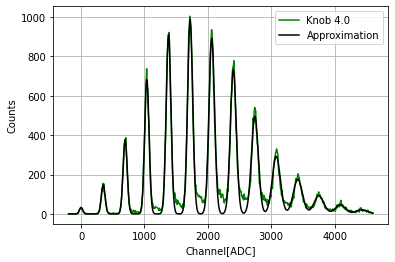

In [ ]:
x14_data = count_400.loc[100:700,'charge']
y14_data = count_400.loc[100:700,'count']

e_mean = np.mean(x14_data)
e_std = stats.sem(x14_data)

print(e_mean, e_std)

amp14 = [10,	20,	379.275102076935,	684.021187142159,
         910.987674336211,	989.246106052808,	891.395955761479,	731.759995356302,
         496.915683861105,	292.772057054148,	175.239419388598,	91.2551713501103,
         45.7473555058299, 17]
mean14 = [1.89930685203896,	350.499008376769,	696.203159165885,	1038.34744735898,
          1380.52775779933,	1721.16318888544,	2062.21294165426,	2402.23233086202,
          2741.96646856351,	3079.19433747237,	3419.29314800409,	3752.15796341333,
          4085.43409846659,	4400]
std14 = [3,	42.3552013550405,	4,	49.0659614850500,
         52.8802709358307,	56.8587501556161,	62.4974433900208,	66.6795835692384,
         76.3671671746640,	90.3269584258771,	101.033590011038,	110.726095183226,
         107.339259831722,	107]

guess14 = amp14 + mean14 + std14

popt14, pcov14 = optimize.curve_fit(fourteen_gaussian, x14_data, y14_data, guess14 )


plt.plot(x14_data,y14_data, 'green', label="Knob 4.0")
#red_patch = mpatches.Patch(color='black', label='Knob 4.0')
plt.xlabel('Channel[ADC]', fontsize=10)
plt.ylabel('Counts', fontsize=10)
plt.grid()
plt.plot(x14_data, fourteen_gaussian(x14_data, *popt14), 'black',label="Approximation")
plt.legend()

#print(popt14)
#print(np.sqrt(np.diag(pcov14)))

Now that we have gotten optimized coefficients, we have to see two physical properties. First, we have to show that the amplitudes of the each Gaussian peaks follow a Poisson distribution. We have the amplitudes on y-axis, number of peaks on x-axis, and have to derive two parameters from this fit: lambda (representing the mean of the Poisson distribution) and the scaling factor (Poisson distribution is normalized. Must find a scale that reverts that to our original amplitude).

In [ ]:
# ERROR HANDLING
fit_amp5,fit_mean5,fit_std5 =  np.array_split(popt5,3)
fit_amp9,fit_mean9,fit_std9 =  np.array_split(popt9,3)
fit_amp14,fit_mean14,fit_std14 =  np.array_split(popt14,3)


std_error14 = np.sqrt(np.diag(pcov14))
amp_e14, mean_e14, std_e14 = np.array_split(std_error14,3)

#print(np.mean(amp_e14 / fit_amp14))

std_error9 = np.sqrt(np.diag(pcov9))
amp_e9, mean_e9, std_e9 = np.array_split(std_error9,3)

std_error5 = np.sqrt(np.diag(pcov5))
amp_e5, mean_e5, std_e5 = np.array_split(std_error5,3)



0.11001349707996082


[0.0210764]
[0.02054588]
[0.0220723]


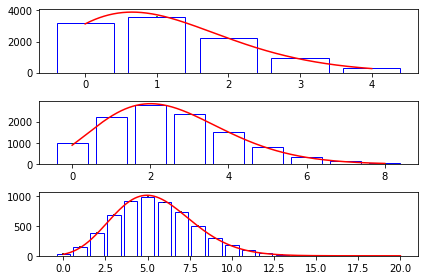

In [ ]:
#Try to describe this in Poisson distribution

x5_plot = np.array(range(5))
x9_plot = np.array(range(9))
x14_plot = np.array(range(14))

pplot5 = np.linspace(0, 4, num=1000)
pplot9 = np.linspace(0, 8, num=1000)
pplot = np.linspace(0, 20, num=1000)

def poisson(x, lamb):
    return np.exp(-lamb)*(lamb**x)/ factorial(x)

#Get the scaling factor
scale_factor5 = sum(fit_amp5)
scale_factor9 = sum(fit_amp9)
scale_factor14 = sum(fit_amp14)
  
#Fit to Poisson Distribution
p5, cov5 = optimize.curve_fit(poisson, x5_plot, fit_amp5 / scale_factor5)
p9, cov9 = optimize.curve_fit(poisson, x9_plot, fit_amp9 / scale_factor9)
p14, cov14 = optimize.curve_fit(poisson, x14_plot, fit_amp14 / scale_factor14)

#Plot them
#plt.subplot(4, 1, 1)
#plt.plot( pplot3, scale_factor3 * poisson(pplot3,*p3))
#plt.plot(fit_amp3)

plt.subplot(3, 1, 1)
plt.plot(pplot5, scale_factor5 * poisson(pplot5,*p5), color='red')
plt.bar(x5_plot, fit_amp5, edgecolor='b', color='white' )
plt.errorbar(x5_plot, fit_amp5, yerr=amp_e5 , fmt='none', ecolor='green')


plt.subplot(3, 1, 2)
plt.plot(pplot9, scale_factor9 * poisson(pplot9,*p9), color='red')
plt.bar(x9_plot, fit_amp9, edgecolor='b', color='white' )
plt.errorbar(x9_plot, fit_amp9, yerr=amp_e9 , fmt='none', ecolor='green')


plt.subplot(3, 1, 3)

plt.plot( pplot, scale_factor14 * poisson(pplot, *p14), color='red')
plt.bar(x14_plot, fit_amp14, edgecolor='b', color='white' )
plt.errorbar(x14_plot, fit_amp14, yerr=amp_e14 , fmt='none', color='black')

p_std_error5 = np.sqrt(np.diag(cov5))
print(p_std_error5)

p_std_error9 = np.sqrt(np.diag(cov9))
print(p_std_error9)

p_std_error14 = np.sqrt(np.diag(cov14))
print(p_std_error14)

plt.tight_layout()


Special table for Knob 4.0, showing its parameters and standard error associated. 

  Peak Number    Height[Count]     error    Center[ADC]      error    Width[ADC]      error
-------------  ---------------  --------  -------------  ---------  ------------  ---------
            0          31.9556  15.8025         1.89931  15.0363         26.3322  15.0362
            1         147.267   14.8175       350.499     3.47962        29.9497   3.47959
            2         379.275   14.2436       696.203     1.40553        32.4119   1.40553
            3         684.021   13.767       1038.35      0.806314       34.6949   0.806318
            4         910.988   13.2612      1380.53      0.628519       37.392    0.62852
            5         989.246   12.7888      1721.16      0.600176       40.2052   0.600176
            6         891.396   12.1983      2062.21      0.698304       44.1924   0.698304
            7         731.76    11.8096      2402.23      0.878643       47.1496   0.878646
            8         496.916   11.0362      2741.97      1.38483        53.9998   1.

1486.5938277092112

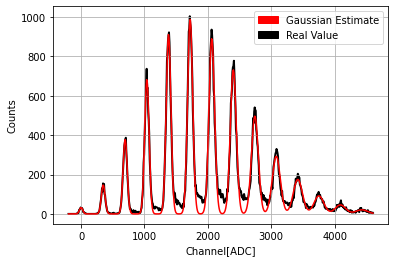

In [ ]:
header = ['Peak Number','Height[Count]','error','Center[ADC]','error','Width[ADC]','error']
peak_number = np.array(list(range(14)))

result = np.stack((peak_number,fit_amp14,amp_e14, fit_mean14,mean_e14, fit_std14,std_e14), axis=-1)
print(tabulate(result, header))

plt.plot(x14_data,y14_data, 'black',linewidth=2.0,zorder=1)
red_patch = mpatches.Patch(color='red', label='Gaussian Estimate')
black_patch = mpatches.Patch(color='black', label='Real Value')
plt.legend(handles=[red_patch, black_patch])
plt.xlabel('Channel[ADC]', fontsize=10)
plt.ylabel('Counts', fontsize=10)
plt.grid()
plt.plot(x14_data, fourteen_gaussian(x14_data,*popt14), 'red',zorder=2)

#j = 0
#while(j < 14):
  #plt.plot(x14_data, gaussian(x14_data,fit_amp14[i],fit_mean14[i],fit_std14[i]), re,zorder=2)
  #j += 1
         
chi , p = stats.chisquare(y14_data, fourteen_gaussian(x14_data, *popt14))
chi
chi / len(y14_data)

#plt.plot())
#np.sum((y14_data - fourteen_gaussian(x14_data, *popt14))**2 / (fourteen_gaussian(x14_data, *popt14) +1)) / len(y14_data)


Try to find the relationship between lamdba and intensity knob number. 

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


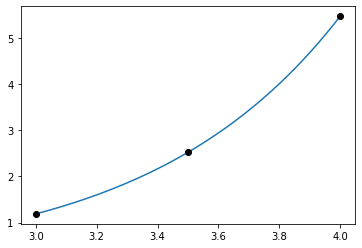

In [ ]:
def exponenial_func(x, a, b, c):
    return a*np.exp(-b*x)+c

lambda_array = np.append(p5, [p9, p14])
count_p = np.array([3, 3.5, 4])

#print(lambda_array, count_p)

pplot_p = np.linspace(3,4, num=1000) 

popt_p, pcov_p = optimize.curve_fit(exponenial_func, count_p, lambda_array, p0=(1, 1e-6, 1))
parameter = np.polyfit(count_p, lambda_array, 4)
p = np.poly1d(parameter)

#print(p)

plt.plot(pplot_p, exponenial_func(pplot_p, *popt_p))
plt.plot(count_p,lambda_array, 'ok')
#plt.plot(pplot_p, exponenial_func(pplot_p, *popt_p))

#print(popt_p)

Next property is that photon charge is quantizes. This is where to calculate the single photon gain by finding the average peak-to-peak distance. If your theory is correct, the mean of each peak should be linear, and their average distance would represent the single photon gain. This single photon gain should be consistent throughout three different intensity.#

No handles with labels found to put in legend.


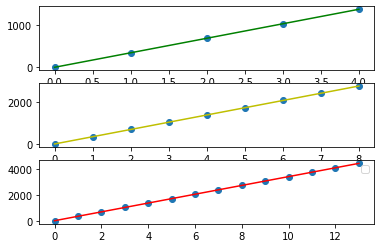

In [ ]:
from scipy import stats

# Perform linear regression on means
"""
plt.subplot(4, 1, 1)
slope3, intercept3, r_value3, p_value3, std_err3 = stats.linregress(x3_plot, fit_mean3)
plt.plot(x3_plot, fit_mean3, 'o')
plt.plot(x3_plot, intercept3 + slope3 * x3_plot, 'b')
"""


plt.subplot(3, 1, 1)
slope5, intercept5, r_value5, p_value5, std_err5 = stats.linregress(x5_plot, fit_mean5)
plt.plot(fit_mean5, 'o')
plt.plot( intercept5 + slope5 * x5_plot, 'g')

plt.subplot(3, 1, 2)
slope9, intercept9, r_value9, p_value9, std_err9 = stats.linregress(x9_plot, fit_mean9)
plt.plot(fit_mean9, 'o')
plt.plot( intercept9 + slope9 * x9_plot, 'y')

plt.subplot(3, 1, 3)
slope14, intercept14, r_value14, p_value14, std_err14 = stats.linregress(x14_plot, fit_mean14)
plt.plot(x14_plot, fit_mean14, 'o')
plt.plot(x14_plot, intercept14 + slope14 * x14_plot, 'r')
plt.errorbar(x14_plot, intercept14 + slope14 * x14_plot, yerr=mean_e14 , fmt='none', color='black')


#plt.plot(x3_plot, fit_mean3)
#plt.plot(x5_plot, fit_mean5)
#plt.plot(x14_plot, fit_mean14)

plt.legend()
plt.show()

Finally, we should try to measure and fit the width of each peak as a function. This, again, is expected to be linear. This is not homogenous, so we expect to parameters (slope, intercept). 

2.6679166992790635 4.959039758118934 5.0371546471524855
27.11321997290897 22.334201244508662 19.774526880017298


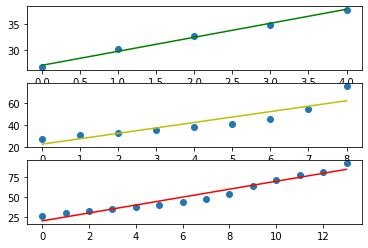

In [ ]:
plt.subplot(3, 1, 1)
slope5, intercept5, r_value5, p_value5, std_err5 = stats.linregress(x5_plot, fit_std5)
plt.plot(fit_std5, 'o')
plt.plot( intercept5 + slope5 * x5_plot, 'g')

plt.subplot(3, 1, 2)
slope9, intercept9, r_value9, p_value9, std_err9 = stats.linregress(x9_plot, fit_std9)
plt.plot(fit_std9, 'o')
plt.plot( intercept9 + slope9 * x9_plot, 'y')

plt.subplot(3, 1, 3)
slope14, intercept14, r_value14, p_value14, std_err14 = stats.linregress(x14_plot, fit_std14)
plt.plot(x14_plot, fit_std14, 'o')
plt.plot(x14_plot, intercept14 + slope14 * x14_plot, 'r')

print(slope5, slope9, slope14)
print(intercept5, intercept9, intercept14)

Now, the final step of this data analysis step is the combine all this into a complete function that describes the entire distribution using five parameters: lamdba, amplitude scaling factor, single photon gain, intercept, and slope for width.

5889.000205077124
[1.89930729e+00 3.50499008e+02 6.96203159e+02 1.03834745e+03
 1.38052776e+03 1.72116319e+03 2.06221294e+03 2.40223234e+03
 2.74196658e+03 3.07919234e+03 3.41932976e+03 3.75184099e+03
 4.08997267e+03 4.42747179e+03]
19.774526880017298
5.0371546471524855


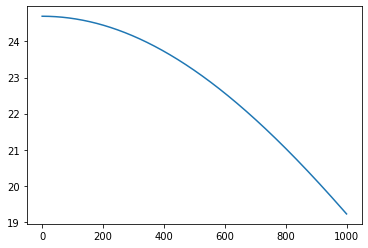

In [ ]:
#Trying to replicate the entire distribution using five parameters
# lamdba : float
# scaling factor : float
# single photon gain : float
# intercept : float
# slope : float
def total_function(N, L, scaling_factor, single_photon_gain, intercept, slope):
    x_plot = np.array(list(range(N)))
    amp = scaling_factor * poisson(x_plot, L)
    mean = x_plot * single_photon_gain
    width = slope * x_plot + intercept

    xx_plot = np.linspace(0,N, 1000)
    result = N_gaussian(xx_plot, amp, mean, width, N)
    plt.plot(result)
    return result

def N_gaussian(x, amp, mean, width, N):
    result = [0.0] * len(x)
    for i in range(N):
      result += gaussian(x, amp[i], mean[i], width[i])
      #print(i_result)

    return result

total_function(14, p14, scale_factor14, fit_mean14, intercept14, slope14)